<a href="https://colab.research.google.com/github/hqjb91/python-notebooks/blob/main/Fruit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
kagglehub.dataset_download('icebearogo/fruit-classification-dataset')

'/kaggle/input/fruit-classification-dataset'

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet normalization
        std=[0.229, 0.224, 0.225]
    )
])

training_dataset = datasets.ImageFolder(root='/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1', transform = transform)

training_loader = DataLoader(
    training_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

for images, label in training_loader:
  print(f'Images Shape: {images.shape}')
  print(f'Label Shape: {label.shape}')
  break # Just load first batch for testing

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Images Shape: torch.Size([64, 3, 224, 224])
Label Shape: torch.Size([64])


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

validation_dataset = datasets.ImageFolder(root='/kaggle/input/fruit-classification-dataset/Fruit_dataset/val1', transform = transform)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2,
)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch

def train_model(model, train_loader, val_loader, num_epochs=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device is: {device}')
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {running_loss/len(train_loader):.3f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.3f}')
        print(f'Validation Accuracy: {100.*correct/total:.2f}%\n')

from torchvision.models import resnet18

model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(training_dataset.classes)) # Add one last layer to output as one of the folder names i.e. classes

train_model(model, training_loader, validation_loader)

Device is: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/2:
Training Loss: 3.627
Validation Loss: 3.178
Validation Accuracy: 18.74%

Epoch 2/2:
Training Loss: 2.971
Validation Loss: 2.775
Validation Accuracy: 26.62%



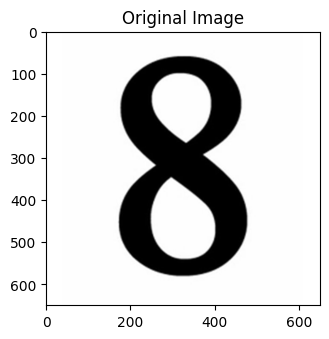

Predicted: eggplant


In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def load_and_preprocess_image(url=None):
  transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
      )
  ])
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))

  plt.figure(figsize=(12, 4))
  plt.subplot(131)
  plt.imshow(image)
  plt.title('Original Image')

  plt.show()

  final = transform(image).unsqueeze(0) # Add batch dimension

  return final

#image_tensor = load_and_preprocess_image('https://as2.ftcdn.net/v2/jpg/00/29/22/15/1000_F_29221584_KvRun7dukDQqTqymgknHgLyqK6VrBsyL.jpg') # Papaya
#image_tensor = load_and_preprocess_image('https://img.freepik.com/premium-photo/durian-fruit-with-cut-half-leaves-isolated-white-surface_252965-916.jpg') # Durian
image_tensor = load_and_preprocess_image(url='https://i5.walmartimages.com/asr/cd8bf985-0245-44dc-ae33-ad46a5488f4f_1.54b6a87ac7f8f79d4de326ef7d451d4f.jpeg') # Not a fruit

def predict_fruit(model, image_tensor):
    model.eval()

    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)

    with torch.no_grad():  # Disable gradient calculation during inference
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

prediction = predict_fruit(model, image_tensor)
print(f'Predicted: {training_dataset.classes[prediction]}')